# Rating of a Plain Fin-Tube Counterflow Air Evaporator
---

**Importing libraries and notebook preparation**

In [18]:
import warnings
from hvac import Quantity
from hvac.fluids import HumidAir, Fluid, CoolPropWarning

warnings.filterwarnings('ignore', category=CoolPropWarning)

from hvac.heat_exchanger.recuperator.fintube.continuous_fin import PlainFinTubeCounterFlowAirEvaporator as Evaporator
from hvac.charts import PsychrometricChart
from hvac.air_conditioning import AirConditioningProcess

Q_ = Quantity

## Selection of the Refrigerant

Define the type of refrigerant:

In [19]:
R134a = Fluid('R134a')

## Definition of the Evaporator

We will use a plain fin-tube, counterflow heat exchanger that is modeled by the class `PlainFinTubeCounterFlowAirEvaporator` (see imports above).

To create an instance of the evaporator model, we need to specify the dimensions of the frontal area, the number of rows, the geometrical characteristics of the heat transfer surfaces, and the thermal conductivity of the fins. The dimensions of the frontal area were determined in our preliminary calculations (see *ex01_prelim.ipynb*).

In [20]:
evp = Evaporator(
    W_fro=Q_(0.731, 'm'),         # width of frontal area
    H_fro=Q_(0.244, 'm'),         # height of frontal area
    N_rows=3,                     # number of rows
    S_trv=Q_(25.4, 'mm'),         # vertical distance between tubes
    S_lon=Q_(22.0, 'mm'),         # horizontal distance between tubes
    D_int=Q_(8.422, 'mm'),        # inner tube diameter
    D_ext=Q_(10.2, 'mm'),         # outer tube diameter
    t_fin=Q_(0.3302, 'mm'),       # fin thickness
    N_fin=1 / Q_(3.175, 'mm'),    # fin density
    k_fin=Q_(237, 'W / (m * K)')  # conductivity of fin material
)

## Rating the Evaporator

On our evaporator model, we set the known operating conditions:
- the state of air entering the evaporator
- the mass flow rate of air through the evaporator
- the state of the liquid/vapor refrigerant mixture that enters the evaporator (either its evaporation temperature or pressure, and its vapor quality)
- the degree of superheat of the refrigerant at the evaporator outlet, which is a setting of the expansion device

The result of rating the evaporator will contain:
- the refrigerant mass flow rate that the expansion device lets through in order to maintain the set degree of superheat
- the resulting state of the air leaving the evaporator
- the heat absorption rate of the refrigerant (i.e., the heat transfer rate from the air to the refrigerant)
- the air-side pressure drop across the evaporator
- the flow length that is used for superheating the refrigerant vapor to the set degree of superheat

The rating routine is an iterative routine that needs to be launched with an initial guess of the mass flow rate of the refrigerant through the evaporator. This initial guess may be the mass flow rate that was determined in the preliminary design calculations (see notebook *ex01_prelim_calc.ipynb*). The criterion that stops the iterative routine is the tolerated deviation (tolerance) between the last and the previous calculated mass flow rate of the refrigerant, which can be set with parameter `tol_m_dot_rfg`. Should the tolerance not be reached after a maximum number of iterations, which can be set with parameter `i_max`, a `ValueError` exception will be raised.

In our preliminary design calculations we selected an evaporation temperature of 5 °C, a condensation temperature of 50 °C, and the degree of refrigerant subcooling at the condenser outlet to be 5 K. Under these conditions, the state of refrigerant entering the evaporator can be determined as:

In [21]:
cnd_rfg_sat_liq = R134a(T=Q_(50, 'degC'), x=Q_(0, 'frac'))
P_cnd = cnd_rfg_sat_liq.P

dT_sc = Q_(5, 'K')

cnd_rfg_out = R134a(T=cnd_rfg_sat_liq.T.to('K') - dT_sc, P=P_cnd)

evp_rfg_sat_vap = R134a(T=Q_(5, 'degC'), x=Q_(1, 'frac'))
P_evp = evp_rfg_sat_vap.P

evp_rfg_in = R134a(P=P_evp, h=cnd_rfg_out.h)

Now, we can set all the operating conditions on the evaporator model to get its performance. The method `solve()` only returns the mass flow rate of refrigerant, but the other output parameters can be read through the corresponding attributes of our evaporator model. 

In [22]:
rfg_m_dot = evp.solve(
    air_in=HumidAir(Tdb=Q_(24, 'degC'), RH=Q_(50, 'pct')),
    air_m_dot=Q_(1500, 'kg / hr'),
    rfg_in=evp_rfg_in,
    dT_sh=Q_(10, 'K'),
    rfg_m_dot_ini=Q_(138.854, 'kg / hr'),
)

Display the results:

In [23]:
print(
    f"m_dot_rfg = {rfg_m_dot.to('kg / hr'):~P.3f}\n"
    f"air_out: {evp.air_out.Tdb.to('degC'):~P.1f} DB, "
    f"{evp.air_out.RH.to('pct'):~P.0f} RH\n"
    f"Q = {evp.Q_dot.to('kW'):~P.3f}\n"
    f"dP_air = {evp.air_dP.to('Pa'):~P.0f}\n"
    f"superheating flow length = {evp.superheating_region.L_flow.to('mm'):~P.0f}"
)

m_dot_rfg = 168.745 kg/h
air_out: 13.0 °C DB, 77 % RH
Q = 6.877 kW
dP_air = 22 Pa
superheating flow length = 17 mm


## Comparison with the Preliminary Calculations

We can now compare these results with our preliminary calculations. By increasing or decreasing the number of rows of the evaporator, we can try to get as close as possible to the desired temperature at which the supply air should leave the evaporator (we could also try with other heat exchanger core geometries, or by altering the superheat-degree setting somewhat).

We find that with three rows of the evaporator, we can get exactly to the air leaving temperature that we want (13 °C). However with this evaporator, we need a mass flow rate of refrigerant around 168.745 kg/h to get at a superheat-degree of 10 K under the operating conditions that we are considering. This is a higher mass flow rate than the mass flow rate that we've determined in our preliminary calculations (138.854 kg/h). Also, the heat absorption rate of the refrigerant is 6.877 kW, which is more than 1.2 kW above what we've determined in our preliminary calculations (5.657 kW). In our preliminary calculations, we assumed that the air leaving the evaporator was near to saturation (RH 90 %). With this evaporator and under the given operating conditions, we get air leaving the evaporator with a relative humidity of 77 %.

In [24]:
air_in = HumidAir(Tdb=Q_(24, 'degC'), RH=Q_(50, 'pct'))

print(f"humidity ratio entering air = {air_in.W.to('g / kg'):~P.3f}")

humidity ratio entering air = 9.340 g/kg


In [26]:
# From preliminary calculation:
air_out_pre = HumidAir(Tdb=Q_(13, 'degC'), RH=Q_(90, 'pct'))
air_m_dot = Q_(1500, 'kg / hr')
evp_Q_pre = air_m_dot * (air_in.h - air_out_pre.h)

print(
    f"heat absorption rate (preliminary) = {evp_Q_pre.to('kW'):~P.3f}",
    f"humidity ratio leaving air (preliminary) = {air_out_pre.W.to('g / kg'):~P.3f}",
    sep='\n'
)

heat absorption rate (preliminary) = 5.657 kW
humidity ratio leaving air (preliminary) = 8.422 g/kg


In [27]:
# From evaporator rating routine:
print(
    f"heat absorption rate (evaporator rating) = {evp.Q_dot.to('kW'):~P.3f}",
    f"humidity ratio leaving air (evaporator rating) = {evp.air_out.W.to('g / kg'):~P.3f}",
    sep='\n'
)

heat absorption rate (evaporator rating) = 6.877 kW
humidity ratio leaving air (evaporator rating) = 7.245 g/kg


We note that the evaporator removes more moisture, and thus latent heat, from the air than what we've assumed in our preliminary calculations. We can look at this on a psychrometric chart:

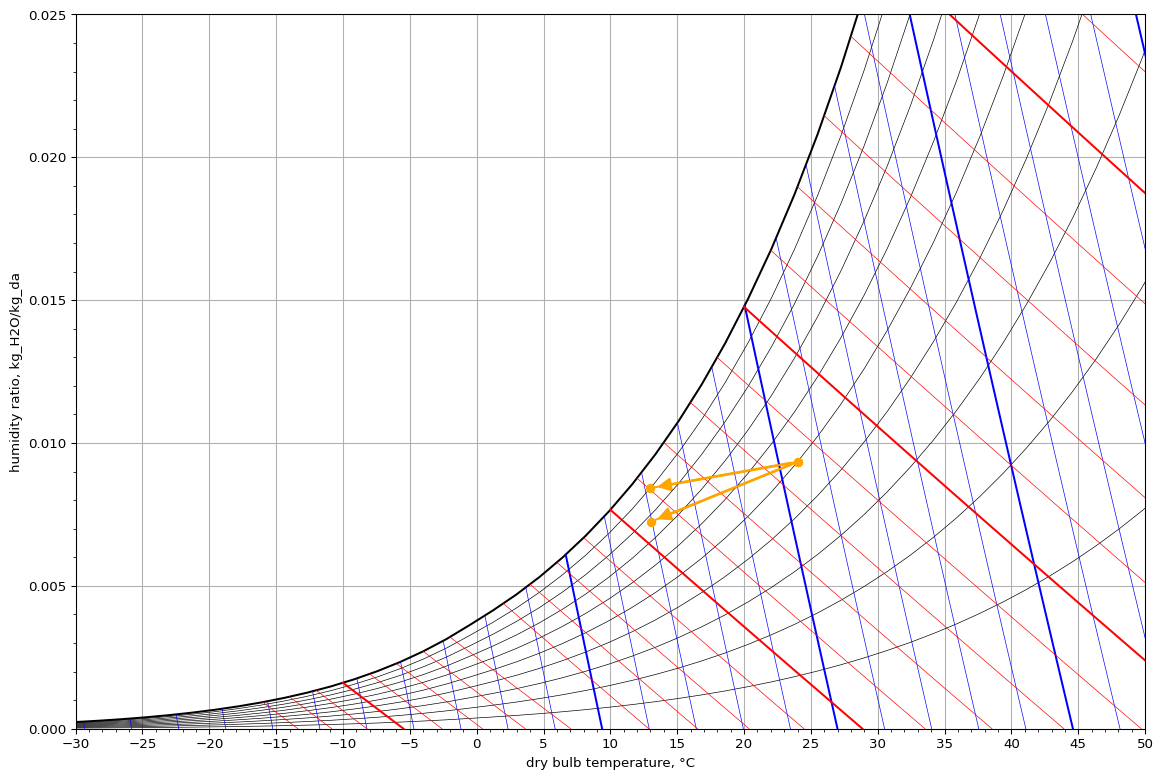

In [29]:
start_point = HumidAir(Tdb=Q_(24, 'degC'), RH=Q_(50, 'pct'))

# According to the preliminary calculation:
psy_chart = PsychrometricChart()
psy_chart.plot_process(
    name='pre_calc',
    start_point=start_point,
    end_point=HumidAir(Tdb=Q_(13, 'degC'), RH=Q_(90, 'pct'))
)

# According to the evaporator rating:
psy_chart.plot_process(
    name='evap_rating',
    start_point=start_point,
    end_point=evp.air_out
)
psy_chart.show()

## Other Properties about Air Evaporator Performance

To find the "apparatus dew point" (ADP), the contact factor, and the sensible and latent cooling capacity of the evaporator, we can model the air cooling process of the evaporator as an instance of the `AirConditioningProcess` class: 

In [30]:
evp_proc = AirConditioningProcess(
    air_in=evp.air_in,
    air_out=evp.air_out,
    m_da=evp.air_m_dot
)

In [31]:
print(
    f"- ADP: {evp_proc.ADP}",
    f"- contact factor = {evp_proc.beta.to('pct'):~P.1f}",
    f"- sensible cooling capacity = {evp_proc.Q_sen.to('kW'):~P.3f}",
    f"- latent cooling capacity = {evp_proc.Q_lat.to('kW'):~P.3f}",
    f"- SHR = {evp_proc.SHR.to('pct'):~P.1f}",
    sep='\n'
)

- ADP: 6.38 °C DB, 5.98 g/kg AH (100 % RH)
- contact factor = 62.2 %
- sensible cooling capacity = -4.659 kW
- latent cooling capacity = -2.231 kW
- SHR = 67.6 %
